In [1]:
import os
os.chdir("/home/idpeshekhonov/AE")

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import argparse
import inspect
import os

import numpy as np
import torch
import torch.nn as nn
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from tqdm import tqdm
from typing import Union, Callable

from configs import Config
from src.data.collators import fc_collator, bw_collator
from src.data.dataset import get_train_dataset, get_val_dataset, SSLDataset, BlackWhiteDataset
from src.model import Simple
from src.model.BWAE import BWAE
from src.model.GANAE import GANAE, Descriminator
from src.model.Simple import SimpleAE
from src.model.base_model import Autoencoder
from src.utils.utils import construct_grid, show_grid, CosineFocalLoss

import torchvision.transforms.functional as T


SQ = 6*6

In [3]:
@torch.no_grad()
def construct_grid(model, dataset, num_images=10, ids=None, f=None, collator=None, mae=False):
    if ids is None:
        ids = np.random.randint(0, len(dataset), size=num_images)
    img_batch = torch.Tensor().to(device)
    restored_img_batch = torch.Tensor().to(device)
    masked_batch = torch.Tensor().to(device)
    for idx in ids:
        img = dataset[idx]
        if collator is not None:
            img = collator([(img, _)])
        else:
            if type(img) == tuple:
                img = img[0]
            img = img.unsqueeze(0)
        img = bw_collator(img.unsqueeze(0), no_targets=True)[0] # !!!!
        img = img.to(device, non_blocking=True)
        restored_img = model(img)
        img_batch = torch.cat([img_batch, img[:, 0, :, :].unsqueeze(1)], dim=0)
        restored_img_batch = torch.cat([restored_img_batch,
                                        restored_img], dim=0)

    img_batch = make_grid(img_batch.cpu(), nrow=num_images, padding=1, normalize=True, value_range=(-1, 1))
    restored_img_batch = make_grid(restored_img_batch.cpu(), nrow=num_images, padding=1, normalize=True,
                                   value_range=(-1, 1))
    if mae:
        masked_batch = make_grid(masked_batch.cpu(), nrow=num_images, padding=1, normalize=True, value_range=(-1, 1))
        grid = torch.cat([img_batch, masked_batch, restored_img_batch], dim=1)
    else:
        grid = torch.cat([img_batch, restored_img_batch], dim=1)
    return grid


def show_grid(grid, img_size=(5, 5)):
    fig, axs = plt.subplots(figsize=(5 * img_size[0], 5 * img_size[1]),
                            squeeze=False)
    grid = grid.detach()
    grid = T.to_pil_image(grid)
    axs[0, 0].imshow(grid)
    axs[0, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
def train_one_epoch(model_G, model_D, train_dataloader, optimizer_G, optimizer_D, criterion,
                    criterion_visual, device="cuda", scheduler_D=None, scheduler_G=None,
                    scheduler_frequency=None, batch_size=32, loss_mix=1.):
    len_dataloader = len(train_dataloader)
    losses_D = 0
    losses_G = 0
    model_G.train()
    model_D.train()
    real_label = torch.ones((batch_size, SQ), device=device)
    fake_label = torch.zeros((batch_size, SQ), device=device)
    with tqdm(total=len_dataloader) as prbar:
        for batch_idx, (features, targets) in enumerate(train_dataloader):
            features = features.to(device, non_blocking=True)
            if targets is not None:
                targets = targets.to(device, non_blocking=True)

            optimizer_D.zero_grad()
            D_pred = model_D(targets)
            loss_D = criterion(D_pred, real_label)
            loss_D.backward()

            fake = model_G(features)
            D_pred = model_D(fake.detach())
            fake_loss_D = criterion(D_pred, fake_label)
            fake_loss_D.backward()
            loss_D += fake_loss_D
            optimizer_D.step()


            optimizer_G.zero_grad()
            D_pred = model_D(fake)
            loss_G = (1 - loss_mix) * criterion(D_pred, real_label) + loss_mix * criterion_visual(fake, targets)
            loss_G.backward()
            optimizer_G.step()

            losses_D += loss_D.detach()
            losses_G += loss_G.detach()

            if scheduler_D is not None and scheduler_frequency == "step":
                scheduler_D.step()
                # scheduler_G.step()

            prbar.set_description(f"D loss: {losses_D / (batch_idx + 1)}, G loss: {losses_G / (batch_idx + 1)}")
            prbar.update(1)

    losses_D /= (batch_idx + 1)
    losses_G /= (batch_idx + 1)
    return losses_D, losses_G


@torch.inference_mode()
def evaluate(model_G, model_D, dataloader, criterion, criterion_visual, device="cuda",
             batch_size=32, loss_mix=1.):
    len_dataloader = len(dataloader)
    losses = 0
    model_D.eval()
    model_G.eval()
    with tqdm(total=len_dataloader) as prbar:
        for batch_idx, (features, targets) in enumerate(dataloader):
            features = features.to(device, non_blocking=True)
            if targets is not None:
                targets = targets.to(device, non_blocking=True)
            fake = model_G(features)
            D_pred = model_D(fake)
            real_label = torch.ones((features.shape[0], SQ), device=device)
            loss_G = (1 - loss_mix) * criterion(D_pred, real_label) + loss_mix * criterion_visual(fake, targets)
            losses += loss_G.detach()
            prbar.set_description(f"epoch loss: {losses / (batch_idx + 1)}")
            prbar.update(1)

    losses /= (batch_idx + 1)
    return losses


def train(model_D, model_G, optimizer_D, optimizer_G, criterion, criterion_visual, scheduler_D, scheduler_G, train_loader, val_dataset,
          val_loader, checkpoint_path, device="cuda", num_epoches=10, scheduler_frequency=None, draw=False, batch_size=32,
          loss_mix=1.):
    train_losses_D = []
    train_losses_G = []
    val_losses = []
    best_loss_value = torch.inf
    os.makedirs(checkpoint_path, exist_ok=True)
    for epoch in range(1, num_epoches + 1):
        epoch_train_losses = train_one_epoch(model_G, model_D, train_loader, optimizer_G, optimizer_D,
                                             criterion, criterion_visual, device, scheduler_D,
                                             scheduler_G, scheduler_frequency, batch_size, loss_mix)
        epoch_val_losses = evaluate(model_G, model_D, val_loader, criterion, criterion_visual, device, batch_size, loss_mix)

        train_losses_D.append(epoch_train_losses[0].cpu())
        train_losses_G.append(epoch_train_losses[1].cpu())
        val_losses.append(epoch_val_losses.cpu())

        if draw:
            plt.figure(figsize=(18, 7))
            x = np.arange(epoch)
            clear_output()
            plt.subplot(1, 2, 1)
            plt.title("Generator loss")
            plt.plot(x, train_losses_G, c="C2", label="train")
            plt.plot(x, val_losses, c="C1", label="val")
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.title("Discriminator loss")
            plt.plot(x, train_losses_D, c="C2")
            plt.show()
            grid = construct_grid(model_G, val_dataset)
            show_grid(grid)
            plt.show()

        if val_losses[epoch - 1] < best_loss_value:
            best_loss_value = val_losses[epoch - 1]
            torch.save(
                {"G": model_G.state_dict(),
                 "D": model_D.state_dict()},
                os.path.join(checkpoint_path, f"epoch_{epoch}.pth")
            )

        if scheduler_D is not None and scheduler_frequency == "epoch":
            scheduler_D.step()
            scheduler_G.step()

    torch.save(
        {"G": model_G.state_dict(),
         "D": model_D.state_dict()},
        os.path.join(checkpoint_path, f"final.pth")
    )

    return train_losses_D, train_losses_G, val_losses


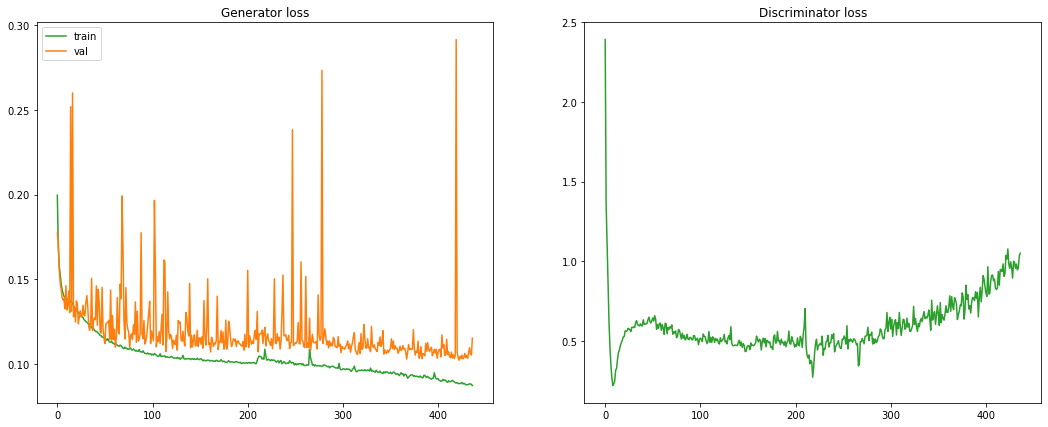

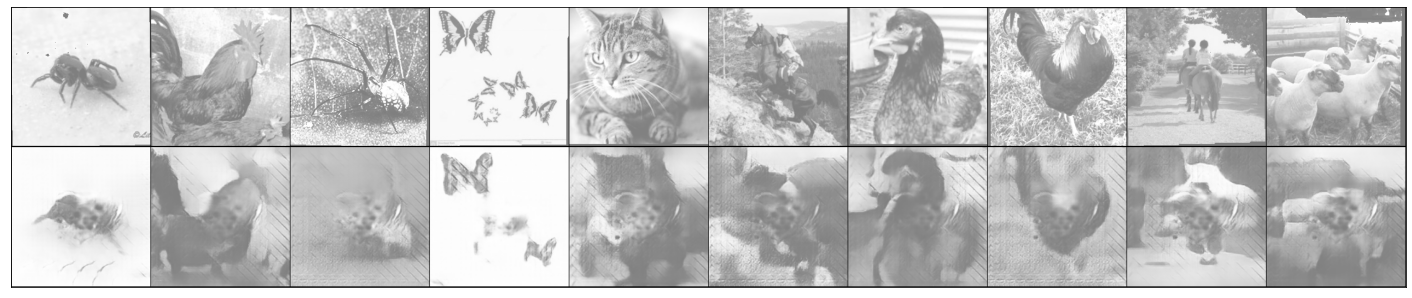

D loss: 1.3399274349212646, G loss: 0.08707012981176376:   9%|▉         | 55/583 [00:03<00:29, 18.05it/s]

In [ ]:
device = "cuda"
num_epoches = 500
num_warmup_epoches = 40
batch_size = 32
loss_mix = .998

model_G = GANAE(bw=True).to(device)
model_D = Descriminator(bw=True).to(device)

# train_dataset = BlackWhiteDataset("data/data/train/*", train=True)
# val_dataset = BlackWhiteDataset("data/data/train/labeled/*", train=False, labled=False)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=bw_collator,
                              num_workers=6, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, collate_fn=bw_collator,
                            num_workers=6, pin_memory=True)
batch = bw_collator([(train_dataset[0][0],)], no_targets=True)

optimizerD = torch.optim.Adam(model_D.parameters(), lr=4e-3, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=4e-3, betas=(0.5, 0.999))


schedulerD = torch.optim.lr_scheduler.OneCycleLR(optimizerD, total_steps=len(train_loader) * num_epoches, max_lr=2e-4,
                                                anneal_strategy="cos", pct_start=num_warmup_epoches/num_epoches, div_factor=100)
# schedulerG = torch.optim.lr_scheduler.OneCycleLR(optimizerG, total_steps=len(train_loader) * num_epoches, max_lr=2e-4,
#                                                 anneal_strategy="cos", pct_start=num_warmup_epoches/num_epoches, div_factor=100)

# schedulerD = None
schedulerG = None

criterion = nn.BCELoss()
criterion_visual = nn.L1Loss()

train(model_D, model_G, optimizerD, optimizerG, criterion, criterion_visual, schedulerD,
      schedulerG, train_loader, val_dataset, val_loader, "checkpoints/gae",
      device, num_epoches, "step", True, batch_size, loss_mix)

In [5]:
@torch.no_grad()
def construct_grid(model, dataset, num_images=10, ids=None, f=None, collator=None, mae=False):
    if ids is None:
        ids = np.random.randint(0, len(dataset), size=num_images)
    img_batch = torch.Tensor().to(device)
    restored_img_batch = torch.Tensor().to(device)
    masked_batch = torch.Tensor().to(device)
    for idx in ids:
        img = dataset[idx]
        if collator is not None:
            img = collator([(img, _)])
        else:
            if type(img) == tuple:
                img = img[0]
            img = img.unsqueeze(0)
        img = img.to(device, non_blocking=True)
        restored_img = model(img)
        img_batch = torch.cat([img_batch, img], dim=0)
        restored_img_batch = torch.cat([restored_img_batch,
                                        restored_img], dim=0)

    img_batch = make_grid(img_batch.cpu(), nrow=num_images, padding=1, normalize=True, value_range=(-1, 1))
    restored_img_batch = make_grid(restored_img_batch.cpu(), nrow=num_images, padding=1, normalize=True,
                                   value_range=(-1, 1))
    if mae:
        masked_batch = make_grid(masked_batch.cpu(), nrow=num_images, padding=1, normalize=True, value_range=(-1, 1))
        grid = torch.cat([img_batch, masked_batch, restored_img_batch], dim=1)
    else:
        grid = torch.cat([img_batch, restored_img_batch], dim=1)
    return grid

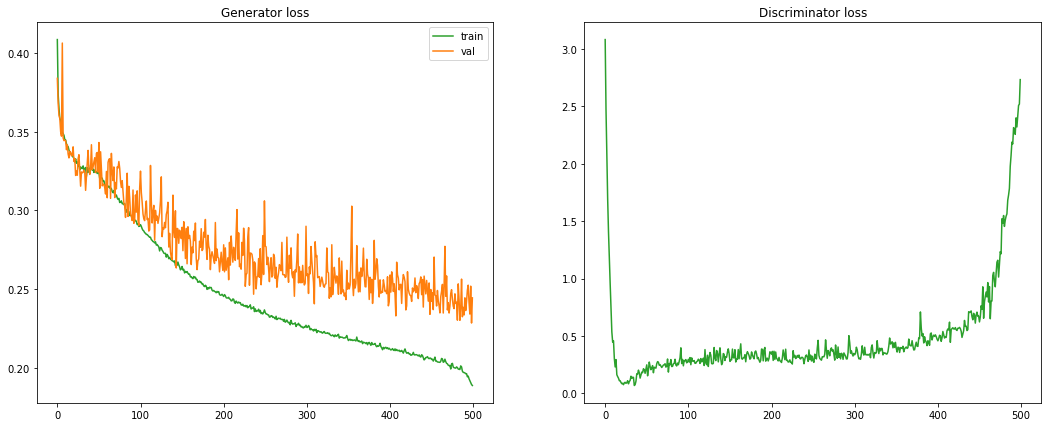

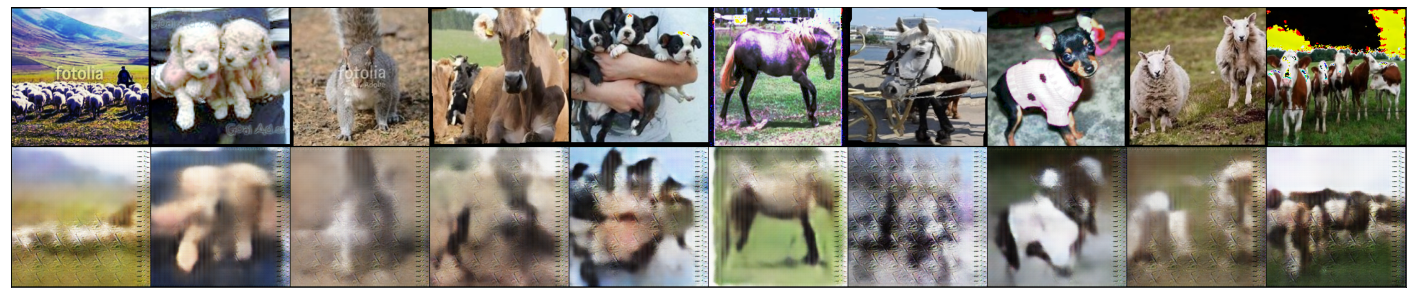

([tensor(3.0803),
  tensor(2.4687),
  tensor(2.0862),
  tensor(1.6875),
  tensor(1.4034),
  tensor(1.1651),
  tensor(0.9541),
  tensor(0.7374),
  tensor(0.5361),
  tensor(0.4464),
  tensor(0.4581),
  tensor(0.3047),
  tensor(0.2307),
  tensor(0.2946),
  tensor(0.1631),
  tensor(0.1464),
  tensor(0.1327),
  tensor(0.1113),
  tensor(0.1107),
  tensor(0.0950),
  tensor(0.0847),
  tensor(0.0884),
  tensor(0.0761),
  tensor(0.0927),
  tensor(0.0967),
  tensor(0.0881),
  tensor(0.0936),
  tensor(0.1106),
  tensor(0.0838),
  tensor(0.1030),
  tensor(0.1138),
  tensor(0.1495),
  tensor(0.1310),
  tensor(0.1411),
  tensor(0.1396),
  tensor(0.0690),
  tensor(0.0760),
  tensor(0.1062),
  tensor(0.1715),
  tensor(0.1671),
  tensor(0.2026),
  tensor(0.1803),
  tensor(0.1333),
  tensor(0.1582),
  tensor(0.1857),
  tensor(0.1807),
  tensor(0.2148),
  tensor(0.2068),
  tensor(0.1750),
  tensor(0.2099),
  tensor(0.2487),
  tensor(0.1534),
  tensor(0.2056),
  tensor(0.2731),
  tensor(0.2348),
  tensor(0

In [6]:
device = "cuda"
num_epoches = 500
num_warmup_epoches_D = 60
num_warmup_epoches_G = 40
batch_size = 128
loss_mix = .998

model_G = GANAE(bw=False).to(device)
model_D = Descriminator(bw=False).to(device)

train_dataset = SSLDataset("data/data/train/*", train=True, )
val_dataset = SSLDataset("data/data/train/labeled/*", train=False, labled=False)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True,
                              num_workers=6, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False,
                            num_workers=6, pin_memory=True)

optimizerD = torch.optim.Adam(model_D.parameters(), lr=4e-3, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=2e-4, betas=(0.5, 0.999))


schedulerD = torch.optim.lr_scheduler.OneCycleLR(optimizerD, total_steps=len(train_loader) * num_epoches, max_lr=2e-4,
                                                anneal_strategy="cos", pct_start=num_warmup_epoches_D/num_epoches, div_factor=1000)
# schedulerG = torch.optim.lr_scheduler.OneCycleLR(optimizerG, total_steps=len(train_loader) * num_epoches, max_lr=2e-4,
#                                                 anneal_strategy="cos", pct_start=num_warmup_epoches_G/num_epoches, div_factor=1000)

# schedulerD = None
schedulerG = None

criterion = nn.BCELoss()
criterion_visual = nn.L1Loss()

train(model_D, model_G, optimizerD, optimizerG, criterion, criterion_visual, schedulerD,
      schedulerG, train_loader, val_dataset, val_loader, "checkpoints/gae",
      device, num_epoches, "step", True, batch_size, loss_mix)